In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# from langchain.agents.agent_types import AgentType
import pandas as pd


from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import OpenAI, ChatOpenAI
from langchain.agents.agent_types import AgentType

In [3]:
import os

import json

f = open('../secrets.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)
 

API_KEY = data['org-key']# great learning resource wasn't working, so I used my own OpenAI API key
OPENAI_API_BASE = "https://api.openai.com/v1/"

os.environ['OPENAI_API_KEY'] = API_KEY
os.environ['OPENAI_API_BASE'] = OPENAI_API_BASE

## Pandas Agent

In [4]:
df = pd.read_csv('../data/csv/plant_syn.csv')

llm = ChatOpenAI(model_name="gpt-4")

agent = create_pandas_dataframe_agent(llm=llm, df=df, verbose=True)

In [5]:
agent.invoke("how many rows are there?")



> Entering new AgentExecutor chain...
Thought: To determine the number of rows in a DataFrame, we can use the shape attribute, which returns a tuple representing the dimensions of the DataFrame. The first element of the tuple is the number of rows.
Action: python_repl_ast
Action Input: df.shape[0]504I now know the final answer
Final Answer: There are 504 rows in the dataframe.

> Finished chain.


{'input': 'how many rows are there?',
 'output': 'There are 504 rows in the dataframe.'}

In [6]:
agent.invoke("what does the average temperature look like?")



> Entering new AgentExecutor chain...
Thought: To answer this question, we need to find the mean of both the temperature_c and temperature_f columns.
Action: python_repl_ast
Action Input: df[['temperature_c', 'temperature_f']].mean()temperature_c    20.010752
temperature_f    68.019354
dtype: float64I now know the final answer.
Final Answer: The average temperature in Celsius is approximately 20.01 and the average temperature in Fahrenheit is approximately 68.02.

> Finished chain.


{'input': 'what does the average temperature look like?',
 'output': 'The average temperature in Celsius is approximately 20.01 and the average temperature in Fahrenheit is approximately 68.02.'}

c:\Me\Duke\Classes\Spring '24\Ind Study\workspace\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
Thought: In order to create a line plot of humidity against moisture, we need to use the matplotlib library. If it's not already imported, we'll need to import it. 
Action: python_repl_ast
Action Input: import matplotlib.pyplot as pltNow that we have imported matplotlib, we can use it to create a line plot of humidity against moisture. We'll need to call the plot function, and pass in the 'humidity' and 'soil_moisture' columns of the dataframe as arguments.
Action: python_repl_ast
Action Input: plt.plot(df['humidity'], df['soil_moisture'])
plt.xlabel('Humidity')
plt.ylabel('Soil Moisture')
plt.title('Humidity vs Soil Moisture')
plt.show()

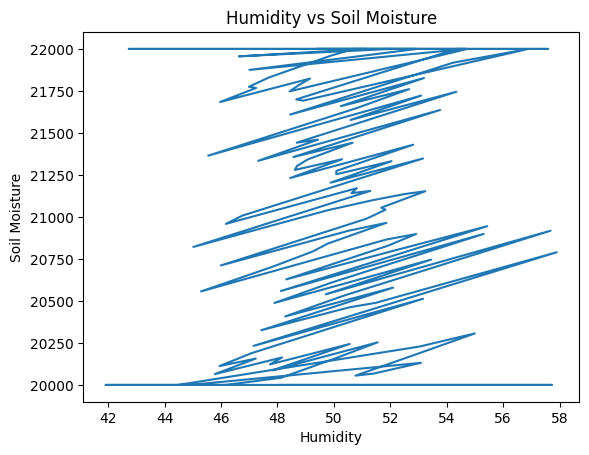

The line plot has been successfully plotted showing the relationship between humidity and soil moisture. The x-axis represents humidity and the y-axis represents soil moisture. The title of the plot is 'Humidity vs Soil Moisture'.
Final Answer: I have successfully created a line plot of humidity against soil moisture using matplotlib. The x-axis represents humidity and the y-axis represents soil moisture. The title of the plot is 'Humidity vs Soil Moisture'.

> Finished chain.


"I have successfully created a line plot of humidity against soil moisture using matplotlib. The x-axis represents humidity and the y-axis represents soil moisture. The title of the plot is 'Humidity vs Soil Moisture'."

In [7]:
# Here we will show the ability of the model to create a plot and comment on the underlying trend in the data
text = "Create a line plot of the humidity against moisture"
agent.run(text)

## RAG Agent

In [8]:
import os
import json, pandas as pd
import re

import langchain

import langchain.document_loaders

from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores.chroma import Chroma
import os
import shutil

from langchain.vectorstores.chroma import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

In [9]:
from langchain.agents.agent_toolkits import create_retriever_tool

In [10]:
loader = DirectoryLoader("../data/txt", glob="*.txt")

In [11]:
# We use the loader created above to load the document
documents = loader.load()

# We split the document into several chunks as mentioned above
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

In [12]:
CHROMA_PATH = "../duke_chroma"

if os.path.exists(CHROMA_PATH):
    shutil.rmtree(CHROMA_PATH)
# Create a new DB from the documents.
db = Chroma.from_documents(
    texts, OpenAIEmbeddings(), persist_directory=CHROMA_PATH
)
db.persist()
print(f"Saved {len(texts)} chunks to {CHROMA_PATH}.")

c:\Me\Duke\Classes\Spring '24\Ind Study\workspace\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


Saved 39 chunks to ../duke_chroma.


In [13]:
retriever = db.as_retriever()

In [14]:
# This is the prompt to create a RAG agent for us
from langchain.agents import load_tools


retriever_name = "plant_os_pdf"
retriever_desc = """The purpose of this tool is to answer questions about the blue indigo false plant and its maintenance."""

rag_tool = create_retriever_tool(
    retriever,
    retriever_name,
    retriever_desc
)

serpapi = "6b59fda7f62498c8341997204d28288d45372c1eb87650af992693ba0ae59b5d"

os.environ['SERPAPI_API_KEY'] = serpapi
search_tool = load_tools(['serpapi'])
tools = [rag_tool, search_tool[0]]


In [15]:
from langchain.agents.agent_toolkits import create_conversational_retrieval_agent


RAG_executor = create_conversational_retrieval_agent(llm=llm, tools=tools, verbose=True) # setting verbose=True to output the thought process of the agent

In [16]:
question = "what is the scientific for the plant?"
user_query = {"input": question}
result = RAG_executor(user_query)
print(f"Result: {result['output']}")

c:\Me\Duke\Classes\Spring '24\Ind Study\workspace\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...

Invoking: `plant_os_pdf` with `{'query': 'scientific name of blue indigo false plant'}`


Blue False Indigo, Baptisia australis Every year the Perennial Plant Association chooses a plant of the year. For 2010 this is Baptisia australis, or blue false indigo. This long-lived perennial legume, hardy in zones 3 to 9, has long been a favorite, although underused, garden plant. Native to eastern North American prairies, meadows, open woods and along streams, blue false indigo got its common name because it was once used as a substitute for true indigo (Indigofera tinctoria, native to southern Asia) which was used to make blue dye. Other common names include blue wild indigo, indigo weed, rattleweed, rattlebush and horse fly weed. B. australis was used medicinally by Native Americans as a purgative, to treat tooth aches and nausea, and as an eyewash. The long-lived A specimen plant of blue false indigo in bloom. plants grow in bushy clumps 3-4 feet ta

In [17]:
question = "who won between Duke and UNC in the latest basketball match and what was the score?"
user_query = {"input": question}
result = RAG_executor(user_query)
print(f"Result: {result['output']}")



> Entering new AgentExecutor chain...

Invoking: `Search` with `latest Duke vs UNC basketball match result`


{'title': 'UNC vs Duke', 'rankings': "NCAA men's basketball", 'games': [{'tournament': "NCAA Division I Men's Basketball", 'arena': 'Cameron Indoor Stadium', 'status': 'Final', 'date': 'Mar 9', 'video_highlights': {'link': 'https://www.youtube.com/watch?v=7REP_yHjhgg&feature=onebox', 'thumbnail': 'https://ssl.gstatic.com/onebox/media/sports/videos/vita/0KIIjSUky2ITTaAm_192x108.jpg', 'duration': '12:57'}, 'teams': [{'name': 'UNC', 'score': '84', 'thumbnail': 'https://ssl.gstatic.com/onebox/media/sports/logos/k5DcdJnt2CqKBuI2SF3ohA_48x48.png'}, {'name': 'Duke', 'score': '79', 'thumbnail': 'https://ssl.gstatic.com/onebox/media/sports/logos/3To2XFGGSc4hvD8WCDsgNQ_48x48.png'}]}, {'tournament': "NCAA Division I Men's Basketball", 'arena': 'Dean Smith Center', 'status': 'Final', 'date': 'Feb 3', 'video_highlights': {'link': 'https://www.youtube.com/watch?v=QD2bdnt0BXU&feature=onebox

## Time Series Agent

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pickle

model_prompt = """
Create a svm regression model to predict the moisture level. 
Use all the columns as features and soil_moisture as the target variable. 
Be sure to clean the data and preprocess it. Split the data into a 70-30 train-test split.
Use the train data to train the model and the test data to evaluate the model. 
Finally, comment on the accuracy of the model on the test data set.
"""

agent.invoke(model_prompt)



> Entering new AgentExecutor chain...
Thought: 
To solve this problem, I will need to follow several steps:
1. Import necessary libraries and modules
2. Clean the data and preprocess it.
3. Split the data into training and testing sets.
4. Train a SVM regression model on the training data.
5. Evaluate the model on the testing data.
6. Comment on the accuracy.

Firstly, I need to check if there are null values in the dataframe.
Action: python_repl_ast
Action Input: df.isnull().sum()date_time        0
temperature_c    0
temperature_f    0
humidity         0
soil_moisture    0
light            0
hour             0
dtype: int64The dataset has no missing values, so we can proceed to the next step which is data preprocessing. The 'date_time' column is a timestamp, so I will convert it to numerical values that can be used in the model. I'll extract the hour from the timestamp as it might have an effect on the soil moisture. I'll also drop the 'temperature_f' column since it's a direct conve

{'input': '\nCreate a svm regression model to predict the moisture level. \nUse all the columns as features and soil_moisture as the target variable. \nBe sure to clean the data and preprocess it. Split the data into a 70-30 train-test split.\nUse the train data to train the model and the test data to evaluate the model. \nFinally, comment on the accuracy of the model on the test data set.\n',
 'output': 'The SVM regression model has a negative coefficient of determination R^2 value on the test data set, indicating that the model is not predicting the soil moisture levels accurately.'}

In [19]:
import pickle

def predict_soil_moisture(date_time, temperature_c, temperature_f, humidity, light):
    date_time = pd.to_datetime(date_time).timestamp()
    features = pd.DataFrame({'date_time': [date_time], 'temperature_c': [temperature_c], 'temperature_f': [temperature_f], 'humidity': [humidity], 'light': [light]})
    with open('../models/moist_predict.pkl', 'rb') as f:
        model = pickle.load(f)
    return model.predict(features)[0]

In [20]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Format the current time
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

print("Formatted current time:", formatted_time)


Formatted current time: 2024-04-13 15:51:30


In [21]:
predict_soil_moisture(formatted_time, 21, 69, 26, 1)

EOFError: Ran out of input